In [1]:
from argparse import ArgumentParser, Namespace
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from IPython.core.pylabtools import figsize
from scipy.ndimage import gaussian_filter

from pyretlife.retrieval_plotting.run_plotting import retrieval_plotting_object
from pyretlife.retrieval_plotting.posterior_plotting import (
    Generate_Parameter_Titles,
    Scale_Posteriors
)
from pyretlife.retrieval.atmospheric_variables import calculate_polynomial_profile

In [17]:
def load_data(
        self,
        log_pressures=True,
        log_mass=True,
        log_abundances=True,
        log_particle_radii=True,
        plot_pt=True,
        plot_physparam=True,
        plot_clouds=True,
        plot_chemcomp=True,
        plot_scatt=True,
        plot_moon=False,
        plot_secondary_parameters=True,
        parameter_units='input',
        custom_unit_titles={},
        custom_parameter_titles={}
):
    """
    Loads and returns the data for the retrieved parameters as well as the upper-log-uniform (ULU), the truth values and the parameter names.

    Parameters
    ----------
    log_pressures :  bool, optional
        If True, applies a logarithmic scale to pressure values. Defaults to True.

    log_mass : bool, optional
        If True, applies a logarithmic scale to mass values. Defaults to True.

    log_abundances :  bool, optional
        If True, applies a logarithmic scale to abundance values. Defaults to True.

    log_particle_radii : bool, optional
        If True, applies a logarithmic scale to particle radii values. Defaults to True.

    plot_pt :  bool, optional
        If True, plots pressure-temperature parameters. Defaults to True.

    plot_physparam : bool, optional
        If True, plots physical parameters. Defaults to True.

    plot_clouds :  bool, optional
        If True, plots cloud parameters. Defaults to True.

    plot_chemcomp : bool, optional
        If True, plots chemical composition parameters. Defaults to True.

    plot_scatt : bool, optional
        If True, plots scattering parameters. Defaults to True.

    plot_moon :  bool, optional
        If True, plots moon parameters. Defaults to False.

    plot_secondary_parameters : bool, optional
        If True, plots secondary parameters. Defaults to True.

    parameter_units : str, optional
        The units to use for plotting. Defaults to 'input', which are the units specified in the config file.

    custom_unit_titles : dict, optional
        A dictionary mapping parameters to custom unit titles. Defaults to an empty dictionary.

    custom_parameter_titles={} : dict, optional
        A dictionary mapping parameters to custom titles. Defaults to an empty dictionary.
    """

    recompute = False
    self.calculate_posterior_spectrum(reevaluate_spectra=False)
    if np.shape(self.retrieved_fluxes)[0] != np.shape(self.posteriors)[0]:
        print('reevaluating spectrum due to dimension error.')
        delattr(self, 'retrieved_fluxes')
        self.calculate_posterior_spectrum(reevaluate_spectra=True)
        recompute = True
        # copy_spectrum(self.results_directory)

    try:
        self.calculate_posterior_pt_profile(n_processes=4,reevaluate_PT=recompute)

        self.deduce_bond_albedo(stellar_luminosity=1.0,
                            	error_stellar_luminosity=0.01,
                            	planet_star_separation=1.0,
                        		error_planet_star_separation=0.01,
                        		true_equilibrium_temperature = 255,
                        		true_bond_albedo = 0.29,
                        		reevaluate_bond_albedo=recompute)
        self.deduce_abundance_profiles(reevaluate_abundance_profiles=recompute)

        self.deduce_gravity(true_gravity = 981)
        self.calculate_true_pt_profile()
        self.deduce_surface_temperature(true_surface_temperature = float(calculate_polynomial_profile(self.parameters['P0']['truth'],self.temp_vars)))

    except Exception as e:
        print(f"Error correcting data for {self.results_directory}: {e}")
        return None, None, None


    parameters_plotted = []
    for parameter in self.parameters:
        if (self.parameters[parameter]['type'] == 'TEMPERATURE PARAMETERS') and plot_pt:
            parameters_plotted += [parameter]
        elif (self.parameters[parameter]['type'] == 'PHYSICAL PARAMETERS') and plot_physparam:
            parameters_plotted += [parameter]
        elif (self.parameters[parameter]['type'] == 'CHEMICAL COMPOSITION PARAMETERS') and plot_chemcomp:
            parameters_plotted += [parameter]
        elif (self.parameters[parameter]['type'] == 'CLOUD PARAMETERS') and plot_clouds:
            parameters_plotted += [parameter]
        elif (self.parameters[parameter]['type'] == 'SCATTERING PARAMETERS') and plot_scatt:
            parameters_plotted += [parameter]
        elif (self.parameters[parameter]['type'] == 'SECONDARY PARAMETERS') and plot_secondary_parameters:
            parameters_plotted += [parameter]
        elif (self.parameters[parameter]['type'] == 'MOON PARAMETERS') and plot_moon:
            parameters_plotted += [parameter]

    local_post = self.posteriors.copy()
    local_truths = {parameter:self.parameters[parameter]['truth'] for parameter in parameters_plotted}

    Generate_Parameter_Titles(self)
    local_titles = {i:self.parameters[i]['title'] for i in parameters_plotted}
    for parameter in parameters_plotted:
        if parameter in custom_parameter_titles:
            local_titles[parameter] = custom_parameter_titles[parameter]

    retrieval_unit =  {i:self.parameters[i]['unit'] for i in parameters_plotted}
    if parameter_units == 'input':
        local_units = {i:self.parameters[i]['input_unit'] for i in parameters_plotted}
    else:
        local_units = retrieval_unit.copy()
        for parameter in parameters_plotted:
            if parameter in parameter_units:
                local_units[parameter] = parameter_units[parameter]

    for parameter in parameters_plotted:
        if not f"{local_units[parameter]:latex}" == '$\\mathrm{}$':
            unit = '\\left['+f"{local_units[parameter]:latex}"[1:-1]+'\\right]'
        else:
            unit = ''
        if parameter in custom_unit_titles:
            unit = '\\left['+custom_unit_titles[parameter][1:-1]+'\\right]'
        local_titles[parameter] = local_titles[parameter][:-1]+unit+'$'

    for parameter in parameters_plotted:
        local_post[parameter] = self.units.truth_unit_conversion(parameter,retrieval_unit[parameter],local_units[parameter],local_post[parameter].to_numpy(),printing=False)
        local_truths[parameter] = self.units.truth_unit_conversion(parameter,retrieval_unit[parameter],local_units[parameter],local_truths[parameter],printing=False)

    local_post, local_truths, local_titles = Scale_Posteriors(self,local_post, local_truths, local_titles, parameters_plotted,
                                                              log_pressures=log_pressures, log_mass=log_mass,
                                                              log_abundances=log_abundances, log_particle_radii=log_particle_radii)

    dataset = {}
    for param in parameters_plotted:
        dataset[param] = local_post[param]

    return dataset, local_truths, parameters_plotted

In [25]:
from pyretlife.retrieval_plotting.run_plotting import retrieval_plotting_object
retrieval_plotting_object.load_data = load_data

def plot_retrievals_old(
        labels,
        folders,
        colors=None,
        params_to_plot=None,
        bins=50,
        fig_title=None,
        output='retrieval_comparison.pdf',
):
    """
    Plot the histogram for a series of retrievals.

    Parameters
    ----------
    labels : dict
        Dictionary mapping run names to legend labels.

    folders : dict
        Dictionary mapping run names to folder with the run data.

    colors : dict, optional
        Dictionary mapping run names to histogram colors. Default is a generic color palette with 10 unique options.

    params_to_plot : list, optional
        List of parameter names to plot. Default is all.

    bins : int or sequence, optional
        Number of histogram bins (default 50).

    fig_title : str, optional
        Title for the whole figure.

    output : str, optional
        name of the output path. Default is 'retrieval_comparison.pdf'.
    """

    # datasets = {}
    # local_truths = []
    # params = []
    # for label in labels.keys():
    #     results = retrieval_plotting_object(folders[label], run_retrieval=False)
    #     ds, lt, pa = results.load_data()
    #     if ds is not None:
    #         datasets[label], local_truths, params = ds, lt, pa

    if not datasets:
        print("No datasets could be loaded.")
        return

    n_params = len(params)
    n_cols = 4
    n_rows = int(np.ceil(n_params / n_cols))

    fig, axs = plt.subplots(
        n_rows, n_cols,
        figsize=(4.5 * n_cols, 3 * n_rows),
        constrained_layout=False
    )
    axs = axs.flatten()

    if colors is None:
        default_colors = [
            "mediumpurple", "indianred", "goldenrod", "steelblue", "darkorange", "seagreen", "firebrick", "royalblue", "darkkhaki"
        ]
        colors = {label: default_colors[i % len(default_colors)] for i, label in enumerate(datasets.keys())}

    for i, param in enumerate(params):
        if params_to_plot is not None and param not in params_to_plot:
            continue

        ax = axs[i]

        for run_name, data in datasets.items():
            if param in data.keys():
                h = ax.hist(
                    data[param],
                    histtype='stepfilled',
                    color=colors.get(run_name, 'gray'),
                    alpha=0.3,
                    linewidth=5,
                    density=True,
                    bins=bins,
                    label=labels.get(run_name, run_name)
                )

        ax.set_title(param, fontsize=12)
        ax.set_ylabel("Prob. density")
        ax.tick_params(labelsize=10)
        ax.grid(False)

        ax.axvline(local_truths[param], color='k', linestyle='--', linewidth=1.5)

    # Hide unused subplots
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    fig.subplots_adjust(top=0.90, bottom=0.08, left=0.07, right=0.98, hspace=0.35, wspace=0.25)

    if fig_title:
        fig.suptitle(fig_title, fontsize=16, weight='bold', y=0.965)

    # Create a single legend above all plots
    handles, legend_labels = axs[0].get_legend_handles_labels()
    fig.legend(
        handles,
        legend_labels,
        loc='upper center',
        bbox_to_anchor=(0.5, 0.935),
        ncol=len(datasets),
        fontsize=11,
        frameon=False
    )
    plt.savefig(output)
    plt.show()

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pyretlife.retrieval_plotting.posterior_plotting import (
    Generate_Parameter_Titles,
    Scale_Posteriors,
)

labels = {
    "R1": r"Perfect $M_p$",
    "R2": r"Unknown $M_p$",
    "R3": "2D prior",
    "R4": r"Gaussian prior $(10\%)$",
    "R5": "Log-Gaussian prior $(0.4)$",
    "R6": "Log-Gaussian prior $(0.6)$",
}

# folders = {
#     "R1": '/mnt/d/timlf/Tim Daten/Desktop/Earthlike2/results/Retrieval1_known/',
#     "R2": '/mnt/d/timlf/Tim Daten/Desktop/Earthlike2/results/Retrieval2_uniform/',
#     "R3": '/mnt/d/timlf/Tim Daten/Desktop/Earthlike2/results/Retrieval3_2d-uniform/',
#     "R4": '/mnt/d/timlf/Tim Daten/Desktop/Earthlike2/results/Retrieval4_gaussian/',
#     "R5": '/mnt/d/timlf/Tim Daten/Desktop/Earthlike2/results/Retrieval5_log-gaussian/',
#     "R6": '/mnt/d/timlf/Tim Daten/Desktop/Earthlike2/results/Retrieval6_log-gaussian/',
# }

folders = {
    "R1": '/mnt/d/timlf/Tim Daten/Desktop/P10/results/Retrieval1_known/',
    "R2": '/mnt/d/timlf/Tim Daten/Desktop/P10/results/Retrieval2_uniform/',
    "R3": '/mnt/d/timlf/Tim Daten/Desktop/P10/results/Retrieval3_2d-uniform/',
    "R4": '/mnt/d/timlf/Tim Daten/Desktop/P10/results/Retrieval4_gaussian/',
    "R5": '/mnt/d/timlf/Tim Daten/Desktop/P10/results/Retrieval5_log-gaussian/',
    "R6": '/mnt/d/timlf/Tim Daten/Desktop/P10/results/Retrieval6_log-gaussian/',
}

retrieval_plotting_object.load_data = load_data

datasets = {}
local_truths = []
params = []
for label in labels.keys():
    results = retrieval_plotting_object(folders[label])
    ds, lt, pa = results.load_data()
    if ds is not None:
        datasets[label], local_truths, params = ds, lt, pa

Conversion performed for truth value of d_syst.
Input value: 10.0 pRT_pc
Converted value: 3.085677581491368e+17 m

Conversion performed for truth value of M_pl.
Input value: 1.0 pRT_M_earth
Converted value: 5.972167867791379e+27 g

Conversion performed for truth value of R_pl.
Input value: 1.0 pRT_R_earth
Converted value: 637810000.0 cm

Conversion performed for prior of R_pl. Prior kind: gaussian
Input values: {'mean': 1, 'sigma': 0.2} pRT_R_earth
Converted value: {'mean': 637810000.0, 'sigma': 127562000.0} cm

Nautilus output not found, trying MultiNest...
  analysing data from /mnt/d/timlf/Tim Daten/Desktop/P10/results/Retrieval1_known/.txt
Loaded previously calculated spectra from /mnt/d/timlf/Tim Daten/Desktop/P10/results/Retrieval1_known/Plots_New/Ret_Spec_Skip_1.pkl.

Loaded previously calculated PT profiles from /mnt/d/timlf/Tim Daten/Desktop/P10/results/Retrieval1_known/Plots_New/Ret_PT_Skip_1.pkl.

Loaded previously calculated Bond albedos from /mnt/d/timlf/Tim Daten/Desktop/

In [22]:
params = ['a_4',
         'a_3',
         'a_2',
         'a_1',
         'a_0',
         'P0',
         'R_pl',
         'N2',
         'O2',
         'CO2',
         'H2O',
         'H2O_Drying',
         'O3',
         'CH4',
         'cloud_fraction',
         'T_eq',
         'A_b',
         'M_pl',
         'g',
         'T_0']

In [40]:
params_plot = [
    r'$\mathbf{a_4}$',
    r'$\mathbf{a_3}$',
    r'$\mathbf{a_2}$',
    r'$\mathbf{a_1}$',
    r'$\mathbf{a_0}$',
    r'$\mathbf{P_0}$',
    r'$\mathbf{R_{pl}}$',
    r'$\mathbf{M_{pl}}$',
    r'$\mathbf{N_2}$',
    r'$\mathbf{O_2}$',
    r'$\mathbf{CO_2}$',
    r'$\mathbf{H_2O}$',
    r'$\mathbf{H_2O\_Drying}$',
    r'$\mathbf{O_3}$',
    r'$\mathbf{CH_4}$',
    r'$\mathbf{cloud\_fraction}$',
    r'$\mathbf{T_{eq}}$',
    r'$\mathbf{A_b}$',
    r'$\mathbf{g}$',
    r'$\mathbf{T_0}$'
]

In [57]:
params = [
    # 'P0',
    # 'R_pl',
    # 'M_pl',
    # 'g',
    # 'T_eq',
    # 'A_b',
    # 'T_0',
    # 'cloud_fraction',
    'N2',
    'O2',
    'CO2',
    'H2O',
    'H2O_Drying',
    'O3',
    'CH4',
]
params_plot = [
    # r'$\mathbf{P_0}$',
    # r'$\mathbf{R_{pl}}$',
    # r'$\mathbf{M_{pl}}$',
    # r'$\mathbf{g}$',
    # r'$\mathbf{T_{eq}}$',
    # r'$\mathbf{A_b}$',
    # r'$\mathbf{T_0}$',
    # r'$\mathbf{cloud\_fraction}$',
    r'$\mathbf{N_2}$',
    r'$\mathbf{O_2}$',
    r'$\mathbf{CO_2}$',
    r'$\mathbf{H_2O}$',
    r'$\mathbf{H_2O\_Drying}$',
    r'$\mathbf{O_3}$',
    r'$\mathbf{CH_4}$',
]

In [23]:
params_latex = [
    '$a_4$',
    '$a_3$',
    '$a_2$',
    '$a_1$',
    '$a_0$',
    '$\log_{10}(P_0\,[\mathrm{bar}])$',
    '$R_{\mathrm{pl}}\,[R_\oplus]$',
    '$\log_{10}(M_{\mathrm{pl}}\,[M_\oplus])$',
    '$\log_{10}(\mathrm{N_2})$',
    '$\log_{10}(\mathrm{O_2})$',
    '$\log_{10}(\mathrm{H_2O})$',
    '$\log_{10}(\mathrm{CO_2})$',
    '$\mathrm{H_2O\_Drying}$',
    '$\log_{10}(\mathrm{O_3})$',
    '$\log_{10}(\mathrm{CH_4})$',
    '$\mathrm{cloud\_fraction}$',
    '$T_{eq}$',
    '$A_b$',
    '$g$',
    '$T_0$'
]

In [24]:
def latex_val(q_low, q_med, q_high, fmt="{:.2f}", tol=1e-3):
    err_low = q_med - q_low
    err_high = q_high - q_med

    if err_low < tol and err_high < tol:
        return fmt.format(q_med)

    return r"${0}^{{+{1}}}_{{-{2}}}$".format(
        fmt.format(q_med),
        fmt.format(err_high),
        fmt.format(err_low),
    )

In [26]:
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import FixedLocator
# col_labels = ["Truth"] + list(labels.values())
#
# latex_lines = []
# latex_lines.append(r"\begin{tabular}{l" + "c" * len(col_labels) + r"}")
# latex_lines.append(r"\hline")
# latex_lines.append(r"\hline")
#
# latex_lines1 = latex_lines + ["Parameter & " + " & ".join(col_labels[:4]) + r" \\"] + ["\hline"]
# latex_lines2 = latex_lines[1:] + ["Parameter & " + " & ".join(["Truth"] + col_labels[4:]) + r" \\"] + ["\hline"]

def plot_retrievals(
        labels,
        folders,
        colors=None,
        params_to_plot=None,
        figsize=(16,16),
        n_cols=8,
        quantiles=(0.16, 0.5, 0.84),
        truth_band_width=0,
        fig_title=None,
        savepath=None,
):
    n_params = len(params)

    # Colors
    if colors is None:
        default = ['firebrick', 'royalblue', 'goldenrod','forestgreen', 'darkviolet',  'darkorange']
        colors = {lab: default[i % len(default)] for i, lab in enumerate(labels.keys())}

    n_rows = int(np.ceil(n_params / n_cols))
    fig, axs = plt.subplots(
        n_rows, n_cols,
        figsize=figsize,
        constrained_layout=False
    )
    axs = axs.flatten()

    for i, param in enumerate(params):
        if params_to_plot is not None and param not in params_to_plot:
            continue

        ax = axs[i]

        # Shaded truth band
        if local_truths[param] is not None:
            t = local_truths[param]
            ax.axvspan(t * (1 - truth_band_width), t * (1 + truth_band_width),
                       color="lightgray", alpha=0.5, zorder=0)

            ax.axvline(x=t, color='gray', linestyle='--', linewidth=1.5, zorder=0)

        # Horizontal category positions
        y_positions = np.arange(len(labels))

        for j, run in enumerate(labels.keys()):

            if param not in datasets[run]:
                continue

            samples = np.asarray(datasets[run][param])
            q_low, q_med, q_high = np.quantile(samples, quantiles)

            # Main interval line
            ax.hlines(
                y_positions[j],
                q_low, q_high,
                color=colors[run],
                linewidth=2
            )

            # Arrows at interval edges
            ax.plot(q_low,  y_positions[j], marker='|', color=colors[run], ms=8)
            ax.plot(q_high, y_positions[j], marker='|', color=colors[run], ms=8)

            # Median marker
            ax.plot(q_med,  y_positions[j], marker='o', color=colors[run], ms=6)

        if i % n_cols == 0:
            ax.set_yticks(y_positions)
            ax.set_yticklabels(labels.values(), fontsize=11)
        else:
            ax.set_yticklabels([])
            ax.set_yticks([])
        # ax.set_yticks(y_positions)
        # ax.set_yticklabels(labels.values())
        ax.set_ylim(-0.25, len(labels) - 0.75)
        ax.invert_yaxis()
        ax.set_title(params_plot[i], fontsize=14, weight="bold", pad=3.5)
        ax.grid(False)


        # #latex table
        # row1 = [params_latex[i]]
        # row2 = [params_latex[i]]
        #
        # # Input / truth column
        # row1.append("{:.2f}".format(local_truths[param]))
        # row2.append("{:.2f}".format(local_truths[param]))
        #
        # for k, run in enumerate(labels.keys()):
        #     if k < 3:
        #         if param not in datasets[run]:
        #             row1.append("--")
        #             continue
        #
        #         samples = np.asarray(datasets[run][param])
        #         q_low, q_med, q_high = np.quantile(samples, quantiles)
        #
        #         row1.append(latex_val(q_low, q_med, q_high))
        #
        #     else:
        #         if param not in datasets[run]:
        #             row2.append("--")
        #             continue
        #
        #         samples = np.asarray(datasets[run][param])
        #         q_low, q_med, q_high = np.quantile(samples, quantiles)
        #
        #         row2.append(latex_val(q_low, q_med, q_high))
        #
        # latex_lines1.append(" & ".join(row1) + r" \\")
        # latex_lines2.append(" & ".join(row2) + r" \\")


    # Remove unused subplots
    for k in range(len(params), len(axs)):
        axs[k].axis("off")

    if fig_title:
        fig.suptitle(fig_title, fontsize=20, weight='bold', y=0.92)

    wspace = 0.015 * max(len(la) for la in labels.values()) + 0.04
    fig.subplots_adjust(hspace=0.3, wspace=0.01)

    for i in range(len(params)):
        ax = axs[i]

        ticks = ax.get_xticks()
        xmin, xmax = ax.get_xlim()

        eps = (xmax - xmin) / 50
        ticks = [t for t in ticks if (t > xmin + eps) and (t < xmax - eps)]

        ax.xaxis.set_major_locator(FixedLocator(ticks))

    if savepath:
        plt.savefig(savepath, dpi=200, bbox_inches="tight")

    plt.show()



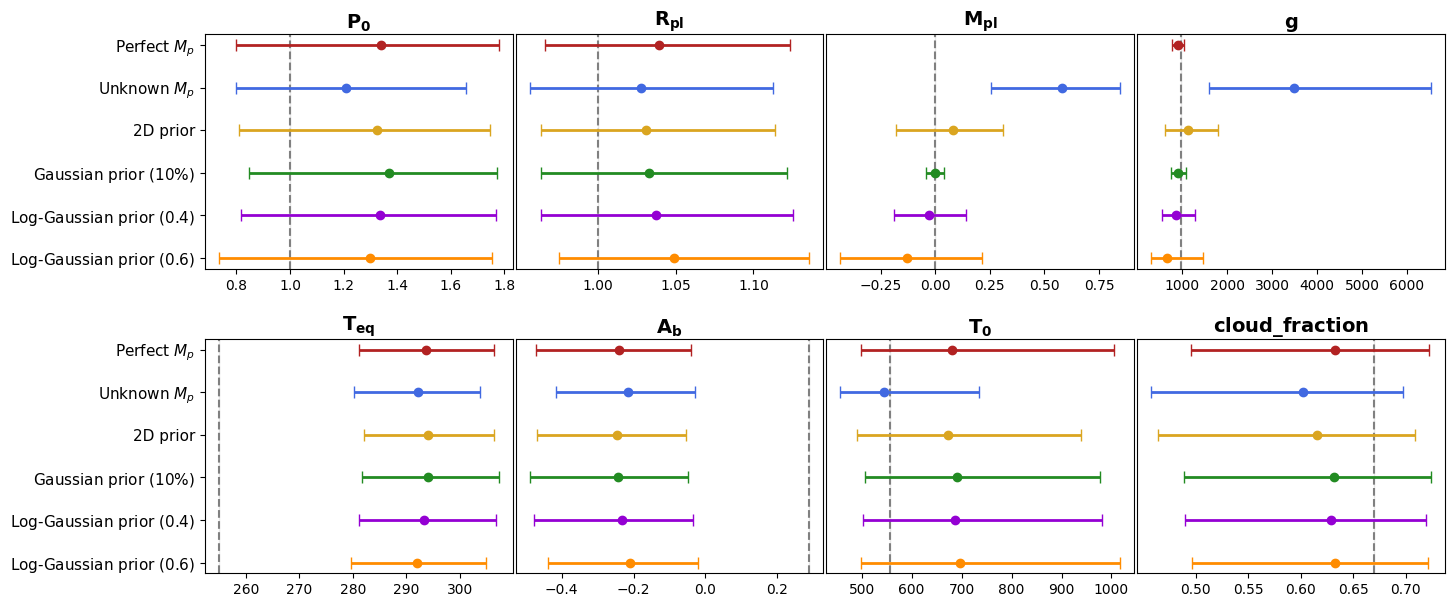

In [46]:
plot_retrievals(labels, folders, figsize=(16,7), n_cols=4,
                          savepath='presicomp_P101.png',
                          # fig_title=r'LIFE Retrieval Comparison - $\mathbf{P_0=10bar}$'
                          )

In [18]:
latex_lines1.append(r"\hline")
latex_lines2.append(r"\hline")
latex_lines2.append(r"\end{tabular}")

latex_table = "\n".join(latex_lines1 + latex_lines2)

with open("parameter_fit_table3.txt", "w") as f:
    f.write(latex_table)

In [3]:
from scipy.interpolate import PchipInterpolator
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FixedLocator, LogLocator, ScalarFormatter
R_earth = 637810000.0
M_earth = 5.972167867791379e+27
masses = np.array([0.125,0.25,0.5,1.0,2.0,4.0,8.0,16.0,32.0])
R100Fe =  np.array([0.445,0.55,0.676,0.823,0.99,1.176,1.38,1.59,1.82])
R100H2O = np.array([0.776,0.952,1.163,1.41,1.71,2.05,2.45,2.9,3.36])
lowerf = PchipInterpolator(masses, R100Fe)
upperf = PchipInterpolator(masses, R100H2O)
lowerfinv = PchipInterpolator(R100Fe, masses)
upperfinv = PchipInterpolator(R100H2O, masses)


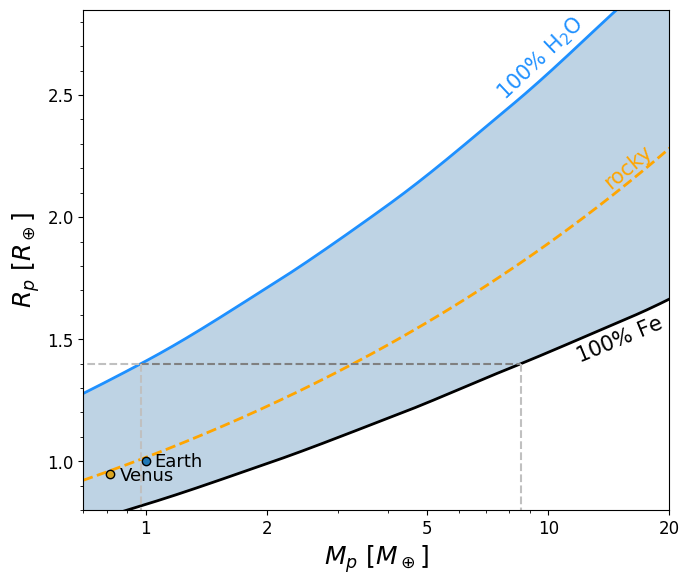

In [10]:
M = np.logspace(-1.3,1.31, 400)  # 0.06–100 Earth masses

# Example power-law relations (replace with your own)
R_low = lowerf(M)
R_high = upperf(M)
R_ref = 1.0154 * M**(1/3.7)

fig, ax = plt.subplots(figsize=(7, 6))

# Shaded composition band
ax.fill_between(
    M,
    R_low,
    R_high,
    color="steelblue",
    alpha=0.35,
    zorder=1
)

# Boundary curves
ax.plot(M, R_low, color="black", lw=2, label="Lower density bound")
ax.plot(M, R_high, color="dodgerblue", lw=2, label="Upper density bound")

# Optional reference curve
if R_ref is not None:
    ax.plot(
        M,
        R_ref,
        color="orange",
        ls="--",
        lw=2,
        label="Reference density"
    )

# Axes styling
ax.set_xscale("log")
ax.set_xlabel(r"$M_p\ [M_\oplus]$", fontsize=18, fontweight="bold")
ax.set_ylabel(r"$R_p\ [R_\oplus]$", fontsize=18, fontweight="bold")

# ax.set_xlim(min(M), max(M))
# ax.set_ylim(0.25, 2.2)
ax.set_xlim(0.7, 20)
ax.set_ylim(0.8, 2.85)
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.set_xscale("log")

ax.xaxis.set_major_locator(LogLocator(base=10, subs=(1, 2, 5)))
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.xaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(1, 10)*0.1))

ax.tick_params(axis="both", labelsize=12)

ax.grid(False)

#Line names
ax.text(
    7.3,
    2.46,
    r"$100\%\  \mathrm{H}_2\mathrm{O}$",
    fontsize=15,
    rotation=43.5,
    ha="left",
    va="bottom",
    color='dodgerblue',
)

ax.text(
    11.5,
    1.39,
    r"$100\%\  \mathrm{Fe}$",
    fontsize=15,
    rotation=22.5,
    ha="left",
    va="bottom",
    color='black',
)

ax.text(
    13.5,
    2.1,
    r"rocky",
    fontsize=15,
    rotation=40,
    ha="left",
    va="bottom",
    color='orange',
)

ax.hlines(1.4, 0, upperfinv(1.4), color='silver', linestyle='--')
ax.hlines(1.4, upperfinv(1.4), lowerfinv(1.4), color='gray', linestyle='--')
ax.vlines(upperfinv(1.4), 1.4, 0, color='silver', linestyle='--')
ax.vlines(lowerfinv(1.4), 1.4, 0, color='silver', linestyle='--')


#Planets
ax.scatter(
    1,
    1,
    color="tab:blue",
    edgecolor="black",
    zorder=5
)
ax.text(
    1 + 0.05,
    1,
    r"Earth",
    fontsize=13,
    ha="left",
    va="center",
    color='black',
)

ax.scatter(
    0.815,
    0.949,
    color="goldenrod",
    edgecolor="black",
    zorder=5
)
ax.text(
    0.815 + 0.05,
    0.949 - 0.01,
    r"Venus",
    fontsize=13,
    ha="left",
    va="center",
    color='black',
)

plt.tight_layout()
plt.savefig("mass_radius.pdf", bbox_inches="tight")

plt.show()


In [24]:
(1.07 - 0.21 * 0.26)

1.0154

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pyretlife.retrieval_plotting.posterior_plotting import (
    Generate_Parameter_Titles,
    Scale_Posteriors,
)

labels = {
    "R1": "Perfect 10",
    "R2": "Unknown 10",
    "R3": "Perfect 30",
    "R4": "Unknown 30",
    "R5": "Perfect 50",
    "R6": "Unknown 50",
}

folders = {
    "R1": '/mnt/d/timlf/Tim Daten/Desktop/sn10/results/Retrieval1_known/',
    "R2": '/mnt/d/timlf/Tim Daten/Desktop/sn10/results/Retrieval2_uniform/',
    "R3": '/mnt/d/timlf/Tim Daten/Desktop/sn30/results/Retrieval1_known/',
    "R4": '/mnt/d/timlf/Tim Daten/Desktop/sn30/results/Retrieval2_uniform/',
    "R5": '/mnt/d/timlf/Tim Daten/Desktop/sn50/results/Retrieval1_known/',
    "R6": '/mnt/d/timlf/Tim Daten/Desktop/sn50/results/Retrieval2_uniform/',
}
retrieval_plotting_object.load_data = load_data

datasets = {}
local_truths = []
params = []
for label in labels.keys():
    results = retrieval_plotting_object(folders[label])
    ds, lt, pa = results.load_data()
    if ds is not None:
        datasets[label], local_truths, params = ds, lt, pa

Conversion performed for truth value of d_syst.
Input value: 10.0 pRT_pc
Converted value: 3.085677581491368e+17 m

Conversion performed for truth value of M_pl.
Input value: 1.0 pRT_M_earth
Converted value: 5.972167867791379e+27 g

Conversion performed for truth value of R_pl.
Input value: 1.0 pRT_R_earth
Converted value: 637810000.0 cm

Conversion performed for prior of R_pl. Prior kind: gaussian
Input values: {'mean': 1, 'sigma': 0.2} pRT_R_earth
Converted value: {'mean': 637810000.0, 'sigma': 127562000.0} cm

Nautilus output not found, trying MultiNest...
  analysing data from /mnt/d/timlf/Tim Daten/Desktop/sn10/results/Retrieval1_known/.txt
Loaded previously calculated spectra from /mnt/d/timlf/Tim Daten/Desktop/sn10/results/Retrieval1_known/Plots_New/Ret_Spec_Skip_1.pkl.

Loaded previously calculated PT profiles from /mnt/d/timlf/Tim Daten/Desktop/sn10/results/Retrieval1_known/Plots_New/Ret_PT_Skip_1.pkl.

Loaded previously calculated Bond albedos from /mnt/d/timlf/Tim Daten/Deskt

In [244]:
def latex_val(q_low, q_med, q_high, fmt="{:.2f}", tol=1e-3):
    err_low = q_med - q_low
    err_high = q_high - q_med

    if err_low < tol and err_high < tol:
        return fmt.format(q_med)

    return r"${0}^{{+{1}}}_{{-{2}}}$".format(
        fmt.format(q_med),
        fmt.format(err_high),
        fmt.format(err_low),
    )


col_labels = ["Truth"] + list(labels.values())

latex_lines = []
latex_lines.append(r"\begin{tabular}{l" + "c" * len(col_labels) + r"}")
latex_lines.append(r"\hline")
latex_lines.append(r"\hline")

latex_lines1 = latex_lines + ["Parameter & " + " & ".join(col_labels[:4]) + r" \\"] + ["\hline"]
latex_lines2 = latex_lines[1:] + ["Parameter & " + " & ".join(["Truth"] + col_labels[4:]) + r" \\"] + ["\hline"]

In [49]:
# --- grouping configuration ---
sn_groups = ['known', 'unknown']
runs_per_group = 3
group_gap = 0.8  # vertical space between SN groups

# group runs by SN
grouped_runs = {
    "known": ['R5', 'R3', 'R1'],
    "unknown": ['R6', 'R4', 'R2'],
}

# flattened run order (sn10 runs, then sn30, then sn50)
ordered_runs = []
y_positions = []
group_centers = {}

y = 0
for sn in sn_groups:
    runs = grouped_runs[sn]
    start_y = y
    for r in runs:
        ordered_runs.append(r)
        y_positions.append(y)
        y += 1
    end_y = y - 1
    group_centers[sn] = 0.5 * (start_y + end_y)
    y += group_gap  # separation between SN groups

y_positions = np.array(y_positions)

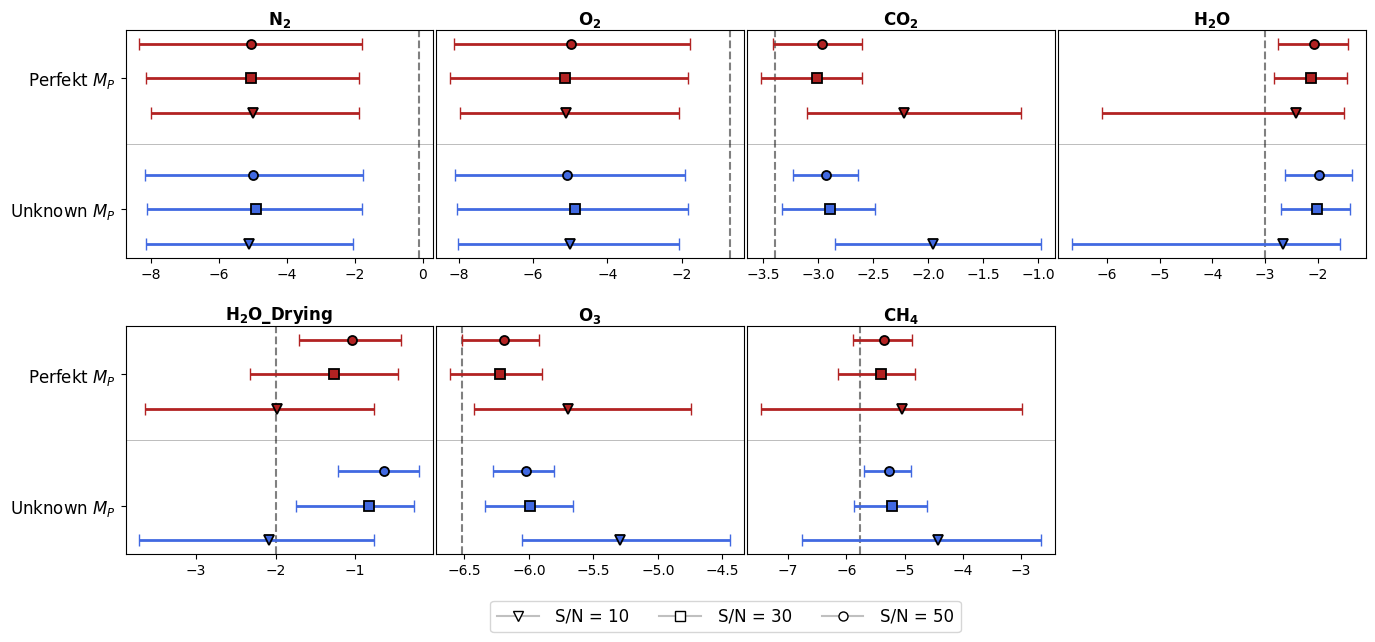

In [58]:
from matplotlib.lines import Line2D
n_params = len(params)
n_cols = 4

c = ['firebrick', 'royalblue']
colors = [c[j//3] for j in range(6)]
# colors = ['firebrick', 'royalblue', 'goldenrod','forestgreen', 'darkviolet',  'darkorange']
markers = ['o', 's', 'v', 'o', 's', 'v']

n_rows = int(np.ceil(n_params / n_cols))
fig, axs = plt.subplots(
    n_rows, n_cols,
    figsize=(16,8),
    # figsize=(16,16),
    constrained_layout=False
)
axs = axs.flatten()

for i, param in enumerate(params):
    ax = axs[i]

    # Shaded truth band
    t = local_truths[param]
    ax.axvline(x=t, color='gray', linestyle='--', linewidth=1.5, zorder=0)

    # Horizontal category positions
    for j, run in enumerate(ordered_runs):

        if param not in datasets[run]:
            continue

        samples = np.asarray(datasets[run][param])
        q_low, q_med, q_high = np.quantile(samples, (0.16, 0.5, 0.84))

        # Main interval line
        ax.hlines(
            y_positions[j],
            q_low, q_high,
            color=colors[j],
            linewidth=2
        )

        # Arrows at interval edges
        ax.plot(q_low,  y_positions[j], marker='|', color=colors[j], ms=8)
        ax.plot(q_high, y_positions[j], marker='|', color=colors[j], ms=8)

        # Median marker
        ax.plot(
            q_med,
            y_positions[j],
            marker=markers[j],
            linestyle='none',
            markerfacecolor=colors[j],
            markeredgecolor='black',
            markeredgewidth=1.3,
            markersize=6.5
        )

    if i % n_cols == 0:
        ticks = []
        ticklabels = [r'Perfekt $M_P$', r'Unknown $M_P$']

        for sn in sn_groups:
            ticks.append(group_centers[sn])

        ax.set_yticks(ticks)
        ax.set_yticklabels(ticklabels, fontsize=12)
    else:
        ax.set_yticks([])
        ax.set_yticklabels([])
    # ax.set_yticks(y_positions)
    # ax.set_yticklabels(labels.values())
    ax.set_ylim(-0.4, 6.2)
    ax.invert_yaxis()
    ax.set_title(params_plot[i], fontsize=12, weight="bold", pad=3.5)
    ax.grid(False)


    ax.axhline(np.mean(y_positions), color="black", lw=0.6, alpha=0.3)


    # #latex table
    # row1 = [params_latex[i]]
    # row2 = [params_latex[i]]
    #
    # # Input / truth column
    # row1.append("{:.2f}".format(local_truths[param]))
    # row2.append("{:.2f}".format(local_truths[param]))
    #
    # for k, run in enumerate(labels.keys()):
    #     if k%2 == 0:
    #         if param not in datasets[run]:
    #             row1.append("--")
    #             continue
    #
    #         samples = np.asarray(datasets[run][param])
    #         q_low, q_med, q_high = np.quantile(samples, (0.16, 0.5, 0.84))
    #
    #         row1.append(latex_val(q_low, q_med, q_high))
    #
    #     else:
    #         if param not in datasets[run]:
    #             row2.append("--")
    #             continue
    #
    #         samples = np.asarray(datasets[run][param])
    #         q_low, q_med, q_high = np.quantile(samples, (0.16, 0.5, 0.84))
    #
    #         row2.append(latex_val(q_low, q_med, q_high))
    #
    # latex_lines1.append(" & ".join(row1) + r" \\")
    # latex_lines2.append(" & ".join(row2) + r" \\")

# Remove unused subplots
for k in range(len(params), len(axs)):
    axs[k].axis("off")

# fig.suptitle('LIFE Retrieval Comparison - S/N', fontsize=20, weight='bold', y=0.92)

wspace = 0.015 * max(len(la) for la in labels.values()) + 0.04
fig.subplots_adjust(hspace=0.3, wspace=0.01)

legend_handles = [
    Line2D([0], [0], marker='v', linestyle='-', color='silver',
           markerfacecolor='white', markeredgecolor='black',
           markersize=6.5, label='S/N = 10'),
    Line2D([0], [0], marker='s', linestyle='-', color='silver',
           markerfacecolor='white', markeredgecolor='black',
           markersize=6.5, label='S/N = 30'),
    Line2D([0], [0], marker='o', linestyle='-', color='silver',
           markerfacecolor='white', markeredgecolor='black',
           markersize=6.5, label='S/N = 50'),
]

fig.legend(
    handles=legend_handles,
    loc='lower center',
    ncol=3,
    frameon=True,
    bbox_to_anchor=(0.5, 0.117),
    fontsize=12,
    handlelength=2.5,
    handletextpad=1.0,
    columnspacing=1.8
)

fig.subplots_adjust(bottom=0.225)
# fig.subplots_adjust(bottom=0.18)

for i in range(len(params)):
        ax = axs[i]

        ticks = ax.get_xticks()
        xmin, xmax = ax.get_xlim()

        eps = (xmax - xmin) / 100
        ticks = [t for t in ticks if (t > xmin + eps) and (t < xmax - eps)]

        ax.xaxis.set_major_locator(FixedLocator(ticks))

savepath = 'presicomp_sn3.png'
if savepath is not None:
    plt.savefig(savepath, dpi=200, bbox_inches="tight")

plt.show()

In [247]:
latex_lines2.append(r"\hline")
latex_lines2.append(r"\end{tabular}")

latex_table = "\n".join(latex_lines1 + latex_lines2)

with open("parameter_fit_table2.txt", "w") as f:
    f.write(latex_table)

In [7]:
input_spec_rebin = np.loadtxt('/mnt/d/timlf/Tim Daten/Desktop/Earthlike_Retrieval/spectra/input_VH2O_test_spectrum.txt')
# input_spec_rebin = np.loadtxt('/mnt/d/timlf/Tim Daten/Desktop/P10/spectra/VH2O_P10_noise.txt')
reference_SNR = 10  # target SNR at reference wavelength
reference_wl = 11.25  # wavelength (in um) where SNR should be set to target

spec_resolution = 100  # spectral resolving power R of input spectrum
min_wavelength = 4.0  # short wavelength cutoff for output spectrum (in um)
max_wavelength = 18.5  # long wavelength cutoff for output spectrum (in um)



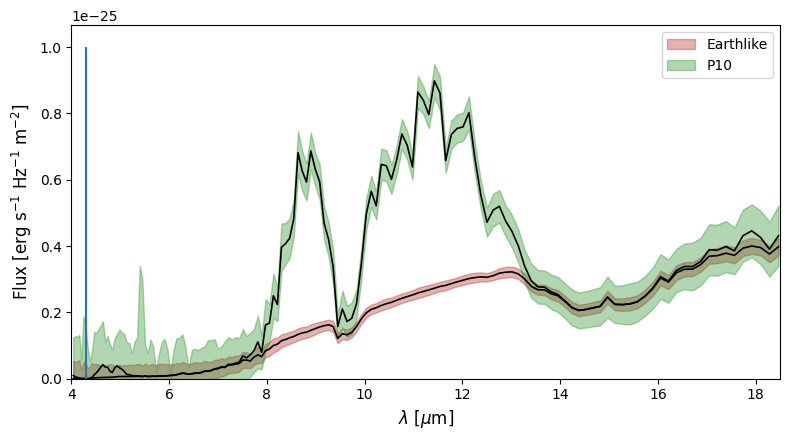

In [81]:
import numpy as np
import matplotlib.pyplot as plt

reference_SNR = 10  # target SNR at reference wavelength
reference_wl = 11.25  # wavelength (in um) where SNR should be set to target

spec_resolution = 100  # spectral resolving power R of input spectrum
min_wavelength = 4.0  # short wavelength cutoff for output spectrum (in um)
max_wavelength = 18.5  # long wavelength cutoff for output spectrum (in um)


# Load the text file
# Assumes: row 0 = wavelength, row 1 = amplitude, row 2 = noise

data1 = np.loadtxt('/mnt/d/timlf/Tim Daten/Desktop/Earthlike_Retrieval/spectra/input_VH2O_test_spectrum.txt')
data2 = np.loadtxt('/mnt/d/timlf/Tim Daten/Desktop/P10/spectra/VH2O_P10_noise.txt')

wavelength1 = data1[:,0]
amplitude1 = data1[:,1]
noise1 = data1[:,2]

wavelength2 = data2[:,0]
amplitude2 = data2[:,1]
noise2 = data2[:,2]

# Plot
plt.figure(figsize=(8, 4.5))

plt.plot(
    wavelength1,
    amplitude1,
    color="black",
    linewidth=1.2,
    linestyle="-",
    # label="Spectrum"
)
plt.fill_between(
    wavelength1,
    amplitude1 - noise1,
    amplitude1 + noise1,
    alpha=0.35,
    label="Earthlike",
    color='firebrick'
)

plt.plot(
    wavelength2,
    amplitude2,
    color="black",
    linewidth=1.2,
    linestyle="-",
)
plt.fill_between(
    wavelength2,
    amplitude2 - noise2,
    amplitude2 + noise2,
    alpha=0.35,
    label="P10",
    color='forestgreen'
    # color='firebrick'
)
plt.vlines(4.3,0,1e-25)

plt.xlabel(r'$\lambda$ [$\mu$m]', fontsize=12)
plt.ylabel(r'Flux [erg s$^{-1}$ Hz$^{-1}$ m$^{-2}$]', fontsize=12)
plt.xlim((min_wavelength, max_wavelength))
plt.ylim(bottom=0.)
# plt.title(r"Earth like Spectrum - $\mathbf{P_0=10}$", fontsize=15, weight='bold')
plt.legend()
plt.tight_layout()

# plt.savefig('spectrum_comp.png', dpi=200, bbox_inches="tight")
plt.show()


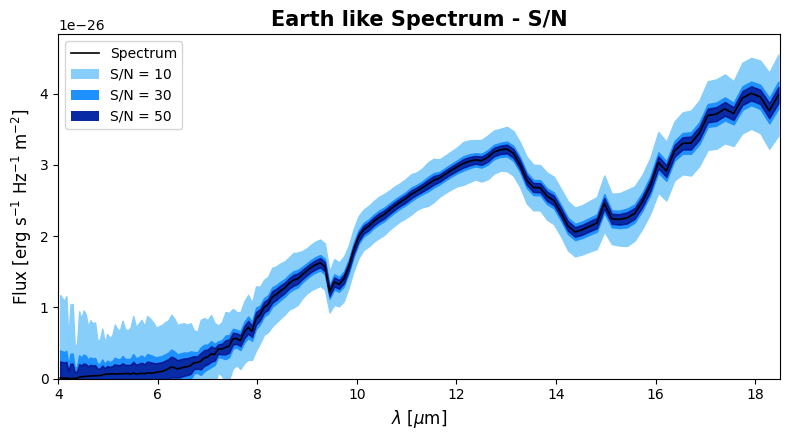

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Load data
# Assumes same wavelength and amplitude, different noise
data1 = np.loadtxt("/mnt/d/timlf/Tim Daten/Desktop/sn10/spectra/VH2O_sn10_noise.txt")
data2 = np.loadtxt("/mnt/d/timlf/Tim Daten/Desktop/sn30/spectra/VH2O_sn30_noise.txt")
data3 = np.loadtxt("/mnt/d/timlf/Tim Daten/Desktop/sn50/spectra/VH2O_sn50_noise.txt")

wavelength = data1[:,0]
amplitude = data1[:,1]
noise1 = data1[:,2]
noise2 = data2[:,2]
noise3 = data3[:,2]

plt.figure(figsize=(8, 4.5))

plt.fill_between(
    wavelength,
    amplitude - noise1,
    amplitude + noise1,
    alpha=1,
    color='lightskyblue'
)

plt.fill_between(
    wavelength,
    amplitude - noise2,
    amplitude + noise2,
    alpha=1,
    color='dodgerblue'
)

plt.fill_between(
    wavelength,
    amplitude - noise3,
    amplitude + noise3,
    alpha=0.7,
    color='navy'
)

plt.plot(
    wavelength,
    amplitude,
    color="black",
    linewidth=1.2,
    linestyle="-",
)



plt.xlabel(r'$\lambda$ [$\mu$m]', fontsize=12)
plt.ylabel(r'Flux [erg s$^{-1}$ Hz$^{-1}$ m$^{-2}$]', fontsize=12)
plt.xlim((min_wavelength, max_wavelength))
plt.ylim(bottom=0.)
plt.title("Earth like Spectrum - S/N", fontsize=15, weight='bold')

legend_elements = [
    Line2D([0], [0], color='black', lw=1.2, label='Spectrum'),
    Patch(facecolor=tuple(c/255 for c in (135, 206, 250)), alpha=1, label='S/N = 10'),
    Patch(facecolor=tuple(c/255 for c in (30, 144, 255)), alpha=1, label='S/N = 30'),
    Patch(facecolor=tuple(c/255 for c in (8, 42, 165)), alpha=1, label='S/N = 50')
]

plt.legend(handles=legend_elements)

plt.tight_layout()

plt.savefig('spectrum_sn.pdf', dpi=400, bbox_inches="tight")
plt.show()

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from pyretlife.retrieval_plotting.run_plotting import retrieval_plotting_object
from pyretlife.retrieval_plotting.posterior_plotting import (
    Generate_Parameter_Titles,
    Scale_Posteriors,
)

labels = {
    "R1": r"Perfect $\mathbf{M_p}$",
    "R2": r"Unknown $\mathbf{M_p}$",
    "R3": "2D prior",
    "R4": r"Gaussian prior $\mathbf{(10\%)}$",
    "R5": r"Log-Gaussian prior $\mathbf{(0.4)}$",
    "R6": r"Log-Gaussian prior $\mathbf{(0.6)}$",
}

# folders = {
#     "R1": '/mnt/d/timlf/Tim Daten/Desktop/Earthlike2/results/Retrieval1_known/',
#     "R2": '/mnt/d/timlf/Tim Daten/Desktop/Earthlike2/results/Retrieval2_uniform/',
#     "R3": '/mnt/d/timlf/Tim Daten/Desktop/Earthlike2/results/Retrieval3_2d-uniform/',
#     "R4": '/mnt/d/timlf/Tim Daten/Desktop/Earthlike2/results/Retrieval4_gaussian/',
#     "R5": '/mnt/d/timlf/Tim Daten/Desktop/Earthlike2/results/Retrieval5_log-gaussian/',
#     "R6": '/mnt/d/timlf/Tim Daten/Desktop/Earthlike2/results/Retrieval6_log-gaussian/',
# }

# folders = {
#     "R1": '/mnt/d/timlf/Tim Daten/Desktop/P10/results/Retrieval1_known/',
#     "R2": '/mnt/d/timlf/Tim Daten/Desktop/P10/results/Retrieval2_uniform/',
#     "R3": '/mnt/d/timlf/Tim Daten/Desktop/P10/results/Retrieval3_2d-uniform/',
#     "R4": '/mnt/d/timlf/Tim Daten/Desktop/P10/results/Retrieval4_gaussian/',
#     "R5": '/mnt/d/timlf/Tim Daten/Desktop/P10/results/Retrieval5_log-gaussian/',
#     "R6": '/mnt/d/timlf/Tim Daten/Desktop/P10/results/Retrieval6_log-gaussian/',
# }


folders = {
    "R1": '/mnt/d/timlf/Tim Daten/Desktop/sn50/results/Retrieval1_known/',
    "R2": '/mnt/d/timlf/Tim Daten/Desktop/sn30/results/Retrieval1_known/',
    "R3": '/mnt/d/timlf/Tim Daten/Desktop/sn10/results/Retrieval1_known/',
    "R4": '/mnt/d/timlf/Tim Daten/Desktop/sn50/results/Retrieval2_uniform/',
    "R5": '/mnt/d/timlf/Tim Daten/Desktop/sn30/results/Retrieval2_uniform/',
    "R6": '/mnt/d/timlf/Tim Daten/Desktop/sn10/results/Retrieval2_uniform/',
}

labels = {
    "R1": r"$\mathbf{S/N=50}$",
    "R2": r"$\mathbf{S/N=30}$",
    "R3": r"$\mathbf{S/N=10}$",
    "R4": r"$\mathbf{S/N=50}$",
    "R5": r"$\mathbf{S/N=30}$",
    "R6": r"$\mathbf{S/N=10}$",
}

results = {f: retrieval_plotting_object(results_directory=folders[f]) for f in folders.keys()}
for r in results.keys():
    # Calculates and saves the PT profiles and spectra for plotting and
    results[r].calculate_posterior_pt_profile(n_processes=16,reevaluate_PT=False,layers=300)
    results[r].calculate_true_pt_profile()
    results[r].calculate_posterior_spectrum(n_processes=4,reevaluate_spectra=False)

unit_titles = {'R_pl':'$\mathrm{R_{Earth}}$','M_pl':'$\mathrm{M_{Earth}}$'}

Conversion performed for truth value of d_syst.
Input value: 10.0 pRT_pc
Converted value: 3.085677581491368e+17 m

Conversion performed for truth value of M_pl.
Input value: 1.0 pRT_M_earth
Converted value: 5.972167867791379e+27 g

Conversion performed for truth value of R_pl.
Input value: 1.0 pRT_R_earth
Converted value: 637810000.0 cm

Conversion performed for prior of R_pl. Prior kind: gaussian
Input values: {'mean': 1, 'sigma': 0.2} pRT_R_earth
Converted value: {'mean': 637810000.0, 'sigma': 127562000.0} cm

Nautilus output not found, trying MultiNest...
  analysing data from /mnt/d/timlf/Tim Daten/Desktop/sn50/results/Retrieval1_known/.txt
Conversion performed for truth value of d_syst.
Input value: 10.0 pRT_pc
Converted value: 3.085677581491368e+17 m

Conversion performed for truth value of M_pl.
Input value: 1.0 pRT_M_earth
Converted value: 5.972167867791379e+27 g

Conversion performed for truth value of R_pl.
Input value: 1.0 pRT_R_earth
Converted value: 637810000.0 cm

Convers

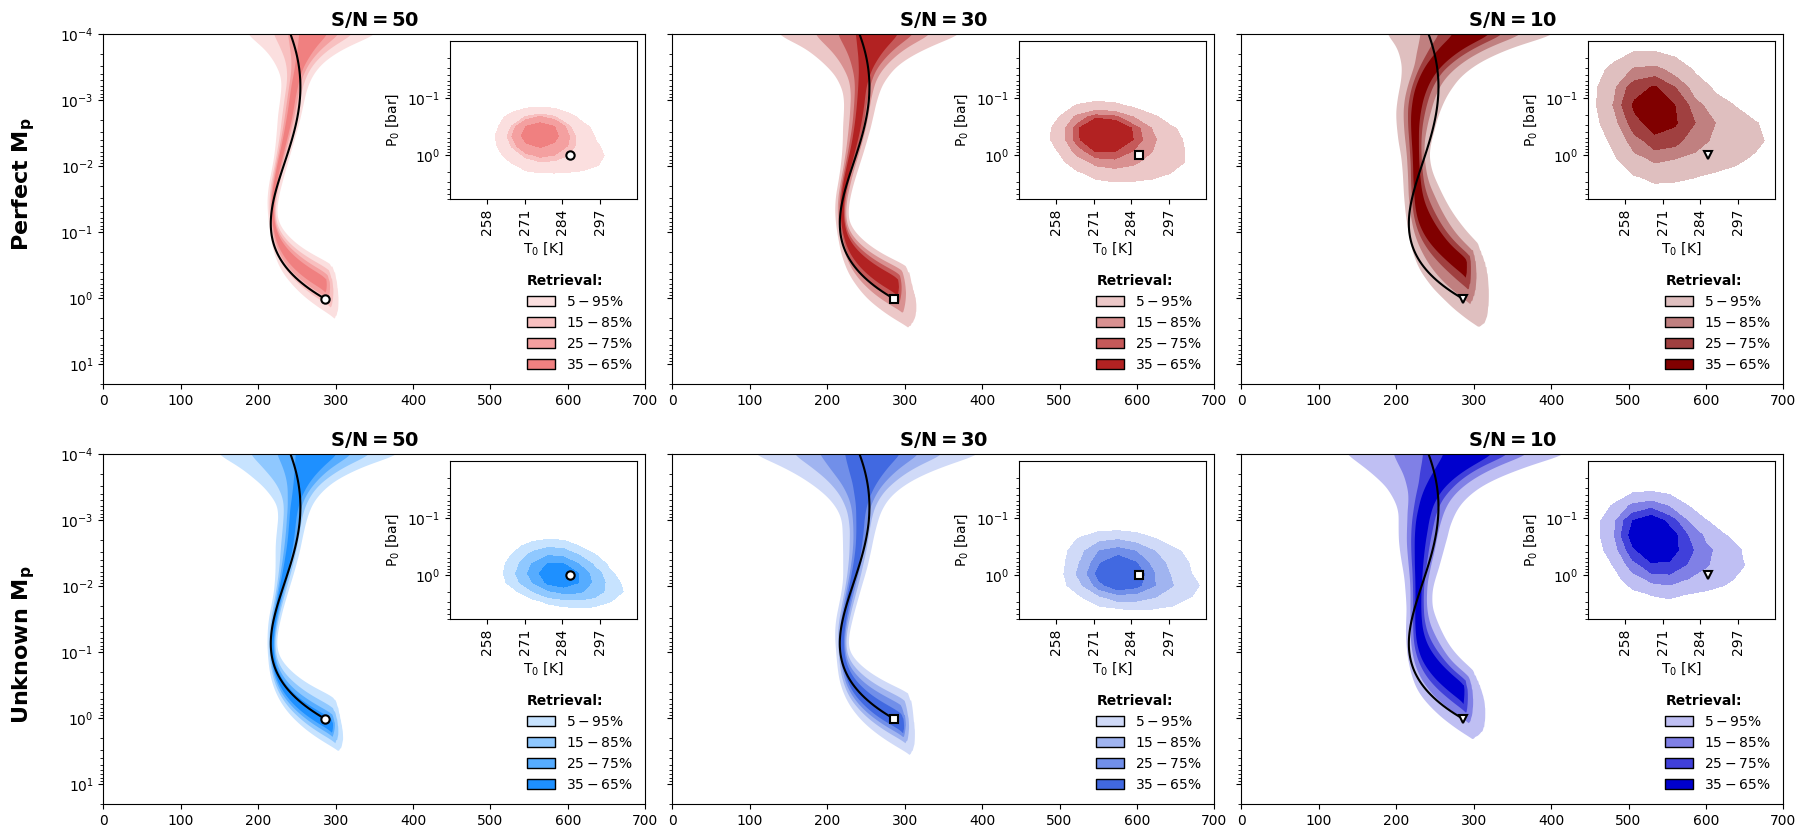

In [16]:
# default = ['firebrick', 'royalblue', 'goldenrod','forestgreen', 'darkviolet',  'darkorange']
default = ['lightcoral', 'firebrick', 'maroon', 'dodgerblue', 'royalblue', 'mediumblue']
colors = {lab: default[i % len(default)] for i, lab in enumerate(labels.keys())}
markers = ['o', 's', 'v', 'o', 's', 'v']

n_plots = len(results)
n_rows = int(np.ceil(n_plots / 3))
fig, axs = plt.subplots(
    n_rows, 3,
    figsize=(20,10),
    constrained_layout=False,
    sharey=True,
)
axs = axs.flatten()

for i, r in enumerate(results.keys()):
    result = results[r]
    ax = axs[i]
    result.plot_retrieved_pt_profile(save = False,
                                     quantiles = [0.05,0.15,0.25,0.35,0.65,0.75,0.85,0.95],
                                     quantiles_title = [r'$5-95\%$',r'$15-85\%$',r'$25-75\%$',r'$35-65\%$'],
                                     x_lim = [0, 700],
                                     y_lim = [1e-4, 2e1],
                                     # x_lim = [0, 2250],
                                     # y_lim = [1e-4, 1e4],
                                     # x_lim_inlay = [249, 315],
                                     # y_lim_inlay = [8e-2, 4],
                                     # x_lim_inlay = [0, 1500],
                                     # y_lim_inlay = [0.7, 300],
                                     x_lim_inlay = [245, 310],
                                     y_lim_inlay = [1e-2, 6],
                                     ax=ax,
                                     color = colors[r],
                                     legend_loc = 'lower right',
                                     plot_truth = True,
                                     leg_truth=False,
                                     # marker='o'
                                     marker=markers[i]
    )

    ax.set_title(labels[r], fontsize=14, weight='bold')

# fig.suptitle(r'P-T Profile Comparison', fontsize=22, weight='bold', y=0.96)
# fig.suptitle(r'P-T Profile Comparison - $\mathbf{P_0=10bar}$', fontsize=22, weight='bold', y=0.96)
# fig.suptitle(r'P-T Profile Comparison - $\mathbf{S/N}$', fontsize=22, weight='bold', y=0.96)

fig.subplots_adjust(hspace=0.2, wspace=0.05)

# Make room on the left for row labels
fig.subplots_adjust(left=0.06, hspace=0.2, wspace=0.05)

# Row labels (figure coordinates)
fig.text(
    0.02, 0.73, r'Perfect $\mathbf{M_p}$',
    va='center', ha='center',
    rotation='vertical',
    fontsize=16, weight='bold'
)

fig.text(
    0.02, 0.27, r'Unknown $\mathbf{M_p}$',
    va='center', ha='center',
    rotation='vertical',
    fontsize=16, weight='bold'
)

# fig.savefig('PT_Comp.png', dpi=200, bbox_inches="tight")
# fig.savefig('PT_P10.png', dpi=200, bbox_inches="tight")
fig.savefig('PT_sn.png', dpi=200, bbox_inches="tight")

plt.show()